In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u

F_comp = 80 # flux completeness %
min_count = 4 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(6, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

In [35]:
# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN8.csv', index_col='Seq')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN8.csv', index_col='Seq')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN8.csv', index_col='Seq')

# All CIGALE sources
oCDFS = pd.read_csv('../DATA/CIGALE/CDFS/results.txt', delim_whitespace=True, index_col='id')
oCOSMOS = pd.read_csv('../DATA/CIGALE/COSMOS/results.txt', delim_whitespace=True, index_col='id')
oUDS = pd.read_csv('../DATA/CIGALE/UDS/results.txt', delim_whitespace=True, index_col='id')

In [36]:
def mask_data(zfourge, cigale):
    
    # Use Mask
    use_mask = zfourge['Use'] == 1
    zfourge = zfourge.loc[use_mask]
    cigale = cigale.loc[use_mask]
    
    # Redshift Mask
    red_mask = (zfourge['zpk'] > redshift_bins[0][0]) & (zfourge['zpk'] <= redshift_bins[-1][1]) 
    zfourge = zfourge.loc[red_mask]
    cigale = cigale.loc[red_mask]
    
    # Nan Mask
    nan_mask = ~np.isnan(cigale['bayes.universe.luminosity_distance'])
    zfourge = zfourge.loc[nan_mask]
    cigale = cigale.loc[nan_mask]
    
    # CIGALE Redshift Mask
    cgz_mask = (cigale['bayes.universe.redshift'] > redshift_bins[0][0]) & (cigale['bayes.universe.redshift'] <= redshift_bins[-1][1])
    zfourge = zfourge.loc[cgz_mask]
    cigale = cigale.loc[cgz_mask]
    
    # Common sources
    common_sources = zfourge.index.intersection(cigale.index)
    zfourge = zfourge.loc[common_sources]
    cigale = cigale.loc[common_sources]
    return zfourge, cigale

print(f'Total number of sources CIGALE: {len(oCDFS) + len(oCOSMOS) + len(oUDS)} \n')
CDFS_m, oCDFS_m = mask_data(CDFS, oCDFS)
COSMOS_m, oCOSMOS_m = mask_data(COSMOS, oCOSMOS)
UDS_m, oUDS_m = mask_data(UDS, oUDS)

# All ZFOURGE sources
df = pd.concat([CDFS_m, COSMOS_m, UDS_m], ignore_index=True)
odf = pd.concat([oCDFS_m, oCOSMOS_m, oUDS_m], ignore_index=True)
print(f'Reduced Number of CIGALE sources: {len(odf)}')


Total number of sources CIGALE: 73758 

Reduced Number of CIGALE sources: 37572


### Total Luminosity

In [ ]:
luminosity = odf['bayes.stellar.lum'].values + odf['bayes.dust.luminosity'].values + odf['bayes.agn.luminosity'].values # Watts
lum_err = np.sqrt(odf['bayes.stellar.lum_err'].values**2 + odf['bayes.dust.luminosity_err'].values**2 + odf['bayes.agn.luminosity_err'].values**2) # Watts

lum_err_up = luminosity + lum_err
lum_err_dn = np.maximum(luminosity - lum_err, 0)

### Stellar Luminosity

In [37]:
luminosity = odf['bayes.stellar.lum'].values + odf['bayes.dust.luminosity'].values # Watts
lum_err = np.sqrt(odf['bayes.stellar.lum_err'].values**2 + odf['bayes.dust.luminosity_err'].values**2) # Watts

lum_err_up = luminosity + lum_err
lum_err_dn = np.maximum(luminosity - lum_err, 0)

### AGN Lumminosity

In [ ]:
# Low AGN Fraction Mask
agn_frac = odf['bayes.agn.fracAGN'].values
mask_low_agn = agn_frac > 0.1
df = df.loc[mask_low_agn]
odf = odf.loc[mask_low_agn]
print(f'Number of sources AGN>0.1: {len(odf)}')

luminosity = odf['bayes.agn.luminosity'].values # Watts
lum_err = odf['bayes.agn.luminosity_err'].values # Watts

lum_err_up = luminosity + lum_err
lum_err_dn = luminosity*(luminosity/lum_err_up)

# num_len = 10
# lum_err_dn = np.maximum(luminosity - lum_err, luminosity*(luminosity/lum_err_up))
# lum_err_dn = np.maximum(luminosity - lum_err, 0)
# lum_err_dn = np.maximum(luminosity - lum_err, 1e32)
# lum_err_dn = np.maximum(luminosity - lum_err, lum_err_up-luminosity)
# lum_err_dn = np.abs(luminosity - lum_err)
# print(lum_err_up[:num_len].tolist())
# print(luminosity[:num_len].tolist())
# print(lum_err_dn[:num_len].tolist())
# # print(luminosity[:num_len]/lum_err_up[:num_len])

# plt.errorbar(odf['bayes.universe.redshift'][:num_len], luminosity[:num_len], yerr=[lum_err_dn[:num_len], lum_err_up[:num_len]], fmt='o', capsize=4)
# plt.yscale('log')
# # plt.ylim(1e33, 1e39)
# # plt.ylim(1e35, 5e36)
# # plt.minorticks_on()
# # plt.xlim(0.8, 1.2)
# plt.show()

In [38]:
z = odf['bayes.universe.redshift'].values.copy() # redshift
d_L = cosmo.luminosity_distance(z).to('m').value # m # Luminsity distance of galaxies

def mask_flux(luminosity):

    # Bolometric Flux
    F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2

    # Bolometric Flux Limit
    Fbol_lim = np.percentile(F_bol, 100-F_comp) # % of the data above perc

    # Bolometric Flux Masks
    mask_fbol = F_bol > Fbol_lim
    return mask_fbol, Fbol_lim

mask_fbol, Fbol_lim = mask_flux(luminosity)
mask_fbol_up, Fbol_lim_up = mask_flux(lum_err_up)
mask_fbol_dn, Fbol_lim_dn = mask_flux(lum_err_dn)

print(f'Flux Limit: {Fbol_lim}')
print(f'Number of galaxies: {len(z[mask_fbol])}')
print(f'Bolometric Flux Completeness: {Fbol_lim:.2e} W/m^2')

Flux Limit: 3.1780769631252552e-18
Number of galaxies: 30057
Bolometric Flux Completeness: 3.18e-18 W/m^2


In [39]:
def lum_lim(z, f_lim):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # W

def compute_volume(redshift_bins, luminosity, Fbol_lim, mask_fbol):
    """ Compute the volume of each redshift bin """
    all_data = []
    L_lims = []
    
    for z_start, z_end in redshift_bins:
        mask_z = (z >= z_start) & (z < z_end)
        
        # Source lumiosity must be greater than the minimum luminosity (from luminosity distance)
        l_lim = lum_lim(z_end, Fbol_lim)
        
        # Mask for luminosity limits
        mask_l = luminosity > l_lim
        
        # Luminosity of galaxies in each redshift bin
        lum_bin = np.log10(luminosity[mask_z & mask_fbol & mask_l]/(3.83*10**26))
        
        # Minimum and maximum distance for the redshift bin
        dmin = cosmo.comoving_distance(z_start).value # Mpc
        dmax = cosmo.comoving_distance(z_end).value # Mpc
        
        # Find the maximum distance for each source
        dmaxs = np.sqrt(luminosity[mask_z & mask_fbol & mask_l] / (4*np.pi*Fbol_lim)) # meters
        dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
            
        # Limit the maximum galaxy distance to the end of the redshift bin
        dmaxs[dmaxs > dmax] = dmax
        
        # Calculate the minimum volume of the redshift bin
        vmin = 4/3 * np.pi * dmin**3 # Mpc^3

        # Calculate the maximum volume of each galaxy
        vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
        
        # Total volume probed accounting for survey area
        vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
        
        # Data
        all_data.append([vol, lum_bin])
        L_lims.append(l_lim)
    
    return all_data, L_lims

all_data, L_lims = compute_volume(redshift_bins, luminosity, Fbol_lim, mask_fbol)
all_data_up, L_lims_up = compute_volume(redshift_bins, lum_err_up, Fbol_lim_up, mask_fbol_up)
all_data_dn, L_lims_dn = compute_volume(redshift_bins, lum_err_dn, Fbol_lim_dn, mask_fbol_dn)
    
print(f'Number of sources: {np.sum([len(v) for v, m in all_data])}')

Number of sources: 26321


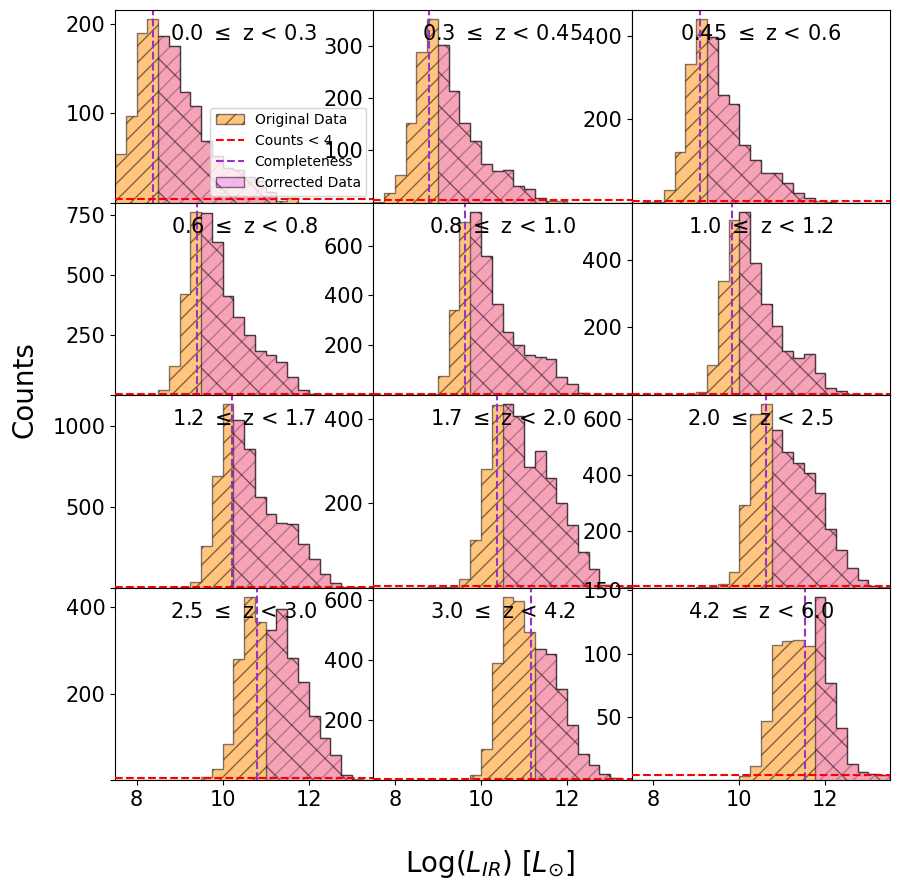

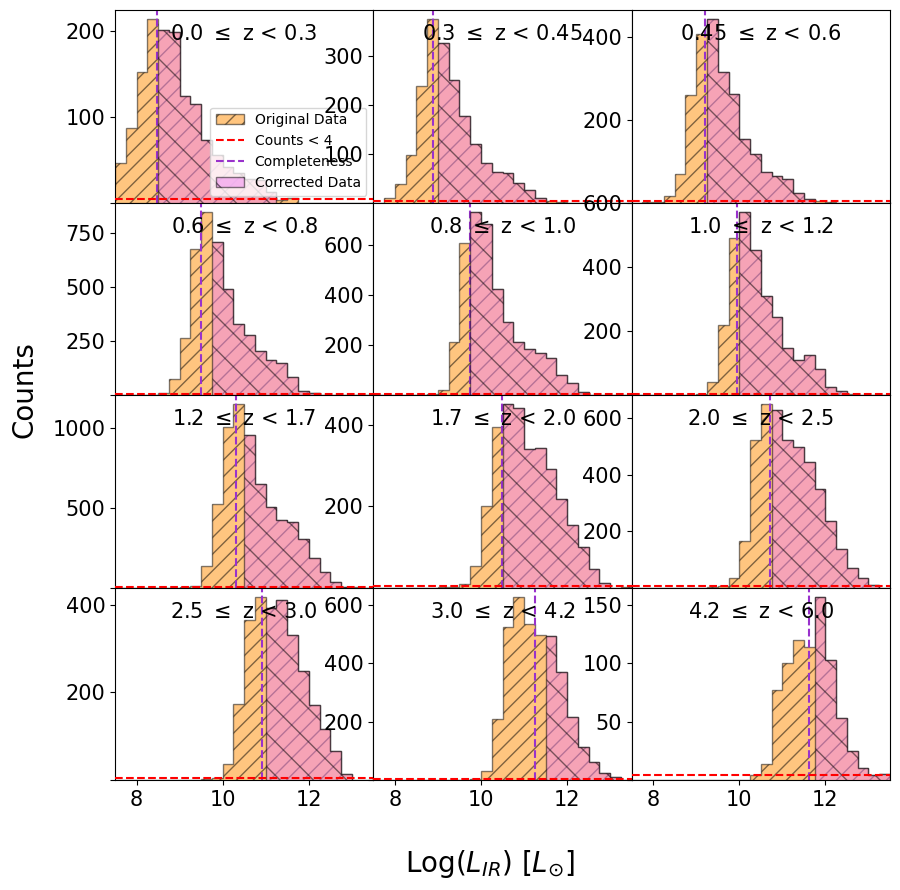

C:\Users\n10480129\AppData\Local\Temp\ipykernel_17924\2090994363.py:8: RuntimeWarning: divide by zero encountered in log10
  _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)],


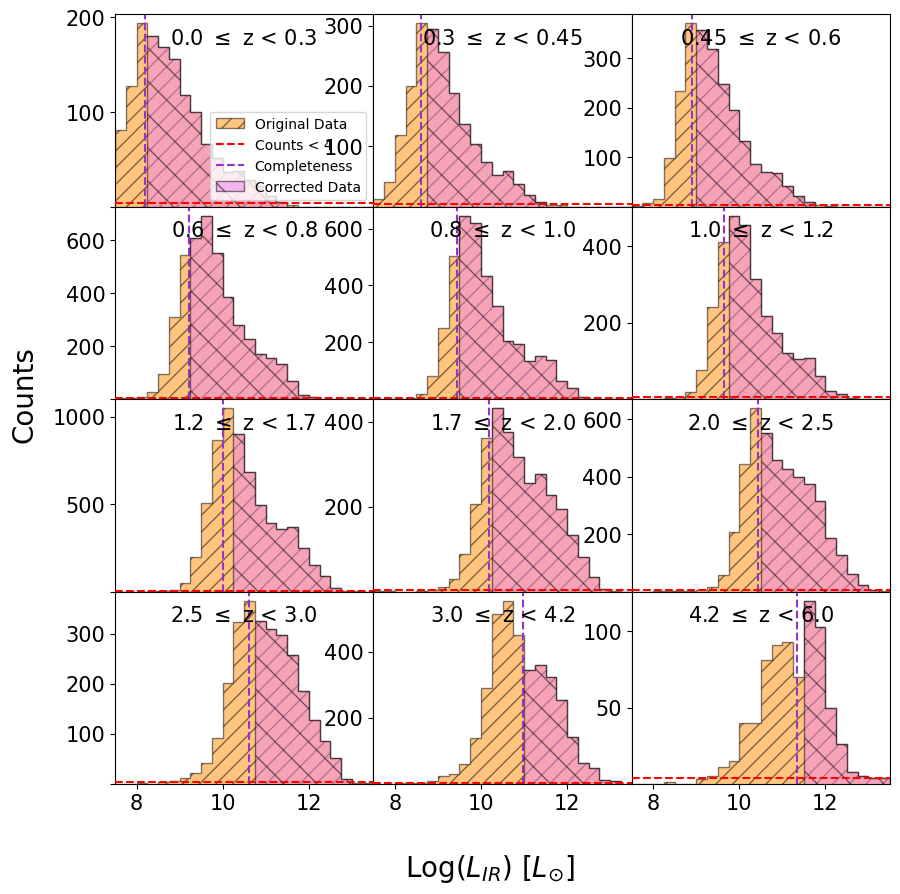

In [40]:
def get_bin_edges(redshift_bins, luminosity, all_data, L_lims):

    fig, axes = plt.subplots(4, 3, figsize=(10, 10), sharex=True)
    bin_edges = []
    for i, (ax, (z_start, z_end), (_, lum), min_l) in enumerate(zip(axes.flatten(), redshift_bins, all_data, L_lims)):
        
        # Bin the original data per redshift bin
        _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], 
            bins=lum_bin_edges, histtype='step', label='Original Data', facecolor='darkorange', edgecolor='black', hatch='//', fill=True, alpha=0.5)
        
        # Bin the new data with the same bins
        c, b = np.histogram(lum, bins=b)
        centers = (b[:-1] + b[1:]) / 2 # bin centers
        
        # Mask the bins with less than the minimum count
        c_mask = c >= min_count
        for _ in range(2): # should only need to run twice
            nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
            c_mask[np.where(c_mask)[0][nci + 1]] = False
        
        b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
        centers = centers[c_mask]
        c = c[c_mask]
        
        # Plot the mask cutoff
        ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}', zorder=10)
        ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label='Completeness')
        ax.set_title(f'{z_start} $\leq$ z < {z_end}', y=0.8, fontsize=15)
        
        # Skip if there are no bins
        if len(c) == 0:
            ax.legend()
            bin_edges.append([])
            continue
        
        # Plot the new, corrected data
        ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True, alpha=0.5)
        ax.tick_params(axis='both', labelsize=15)
        ax.set_xlim(7.5, 13.5)
        ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
        if i == 0:
            ax.legend(loc='lower right')
        bin_edges.append(b)
    
    fig.supylabel('Counts', fontsize=20)
    fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', fontsize=20)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()
    
    return bin_edges

bin_edges = get_bin_edges(redshift_bins, luminosity, all_data, L_lims)
bin_edges_up = get_bin_edges(redshift_bins, lum_err_up, all_data_up, L_lims_up)
bin_edges_dn = get_bin_edges(redshift_bins, lum_err_dn, all_data_dn, L_lims_dn)

[0.03871, 0.03642, 0.0258, 0.02247, 0.01436, 0.01082, 0.00812, 0.00749, 0.00583, 0.00499, 0.0025]
[0.03132, 0.02227, 0.01592, 0.01218, 0.0076, 0.00624, 0.00645, 0.00333, 0.00271, 0.00083]
[0.02507, 0.01631, 0.01493, 0.00869, 0.00636, 0.00441, 0.00441, 0.00296, 0.00139, 0.00063]
[0.02461, 0.02071, 0.01344, 0.01049, 0.00805, 0.00597, 0.00542, 0.00441, 0.0024, 0.00065, 0.00019]
[0.01812, 0.01379, 0.00896, 0.00618, 0.00497, 0.00399, 0.00374, 0.0036, 0.00177, 0.00106, 0.0002]
[0.01117, 0.00806, 0.00557, 0.00417, 0.00265, 0.00226, 0.00251, 0.00134, 0.00043, 0.00027]
[0.00715, 0.0059, 0.00387, 0.00311, 0.00273, 0.0027, 0.00187, 0.00121, 0.00059, 0.00021]
[0.00451, 0.00421, 0.00298, 0.00335, 0.00271, 0.00208, 0.00153, 0.00087, 0.00047, 7e-05]
[0.00337, 0.00289, 0.00267, 0.00244, 0.00203, 0.00125, 0.00079, 0.00042, 0.00015, 4e-05]
[0.0021, 0.00238, 0.00171, 0.00136, 0.00089, 0.00058, 0.00035, 7e-05]
[0.00117, 0.00112, 0.0008, 0.00048, 0.00023, 0.00013, 6e-05, 2e-05]
[0.0003, 0.00016, 8e-05, 3e-

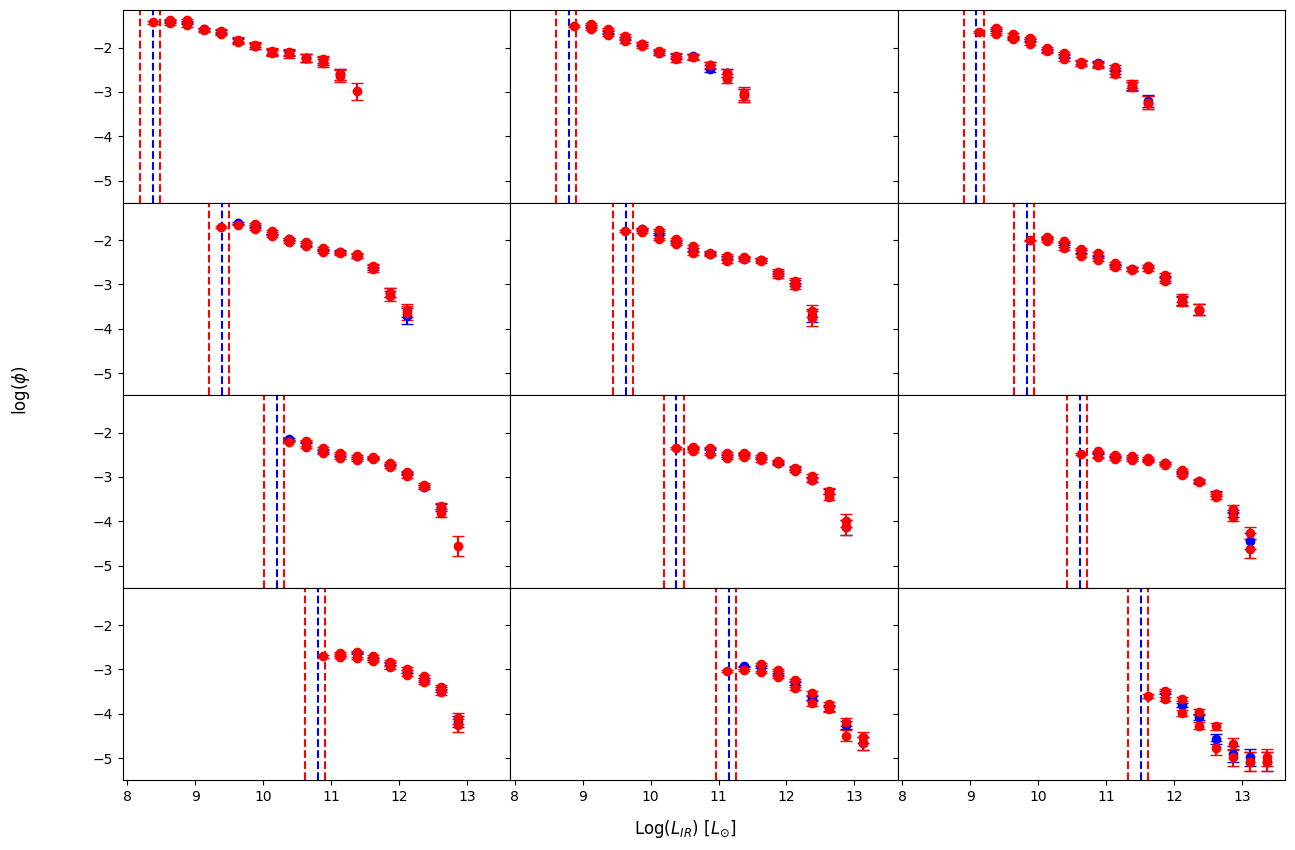

In [41]:
def number_density(all_data, bin_edges):
    lum_centers, phi, phi_e = [], [], []

    # Volume and luminosity are already binned by redshift
    for (vol, lum), bin, in zip(all_data, bin_edges):
        
        try:
            delta_log_l = np.diff(bin)[0]
        except IndexError:
            lum_centers.append([])
            phi.append([])
            phi_e.append([])
            continue
        
        lum_centers_z, phi_z, phi_e_z = [], [], []

        # Bin by luminosity
        for lum_start, lum_end in zip(bin, bin[1:]):
            mask = (lum >= lum_start) & (lum < lum_end)
            vol_lum_bin = vol[mask]
            
            # Calculate the number density
            phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
            phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
            
            # Save the luminosity bin and number density
            lum_centers_z.append((lum_start + lum_end) / 2)
            phi_z.append(phi_val)
            phi_e_z.append(phi_err)
        
        # Save the luminosity bins and number densities
        lum_centers.append(lum_centers_z)
        phi.append(np.array(phi_z))
        phi_e.append(np.array(phi_e_z))
        
    return lum_centers, phi, phi_e

lum_centers, phi, phi_e = number_density(all_data, bin_edges)
lum_centers_up, phi_up, phi_e_up = number_density(all_data_up, bin_edges_up)
lum_centers_dn, phi_dn, phi_e_dn = number_density(all_data_dn, bin_edges_dn)
    
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

def plot_luminosity_function(axes, lum_centers, phi, phi_e, redshift_bins, L_lims, color):
    for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), L_lims):
        try:
            yerr = np.array(e) / (np.array(p) * np.log(10))
        except TypeError:
            continue
        ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4, color=color)
        ax.axvline(np.log10(min_l/(3.83*10**26)), color=color, linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
        print(np.round(p,5).tolist())

plot_luminosity_function(axes, lum_centers, phi, phi_e, redshift_bins, L_lims, 'blue')
print()
plot_luminosity_function(axes, lum_centers_up, phi_up, phi_e_up, redshift_bins, L_lims_up, 'red')
print()
plot_luminosity_function(axes, lum_centers_dn, phi_dn, phi_e_dn, redshift_bins, L_lims_dn, 'red')

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('LF No Error Prop.png', bbox_inches='tight')
plt.show()   

In [42]:
# Luminosity Centers
centers = [(b[:-1] + b[1:]) / 2 for b in bin_edges]
centers_up = [(b[:-1] + b[1:]) / 2 for b in bin_edges_up]
centers_dn = [(b[:-1] + b[1:]) / 2 for b in bin_edges_dn]

# for i, (c, c_up, c_dn, p, p_up, p_dn) in enumerate(zip(centers, centers_up, centers_dn, phi, phi_up, phi_dn)):
#     # Find the indices in the original sublist (list1) and use them to extract from the array_set
#     indices_up = np.isin(c_up, c)  # Boolean mask for matching values
#     indices_dn = np.isin(c_dn, c)  # Boolean mask for matching values
    
#     # Insert 0 at the beginning if the length of c_up is less than c     
#     if len(c_up[indices_up]) < len(c):
#         c_up = np.insert(c_up[indices_up], 0, False)
#         p_up = np.insert(p_up[indices_up], 0, np.sqrt(2)*max(p_up[indices_up]))
#     else:
#         c_up = c_up[indices_up]
#         p_up = p_up[indices_up]
    
#     # Insert 0 at the end if the length of c_dn is less than c
#     if len(c_dn[indices_dn]) < len(c):
#         c_dn = np.insert(c_dn[indices_dn], len(c_dn[indices_dn]), False)
#         p_dn = np.insert(p_dn[indices_dn], len(p_dn[indices_dn]), 0)
#     else:
#         c_dn = c_dn[indices_dn]
#         p_dn = p_dn[indices_dn]
    
#     # Update the centers and phi values with the corrected values
#     centers_up[i] = c_up
#     centers_dn[i] = c_dn
#     phi_up[i] = p_up
#     phi_dn[i] = p_dn
    
# for pu, pd, pp in zip(phi_up, phi_dn, phi):
#     print(f'up: {np.round(pu,4).tolist()}')
#     print(f'p : {np.round(pp,4).tolist()}')
#     print(f'dn: {np.round(pd,4).tolist()}')
#     print()

for j, (c, c_up, c_dn, p, p_up, p_dn) in enumerate(zip(centers, centers_up, centers_dn, phi, phi_up, phi_dn)):
    # print(np.round(p_up,5).tolist())
    # print(np.round(p,5).tolist())
    # print(np.round(p_dn,5).tolist())
    # print()
    
    indices_up = np.isin(c_up, c)  # Boolean mask for matching values
    indices_dn = np.isin(c_dn, c)  # Boolean mask for matching values
    
    
    c_up = c_up[indices_up]
    c_dn = c_dn[indices_dn]
    
    p_up = p_up[indices_up]
    p_dn = p_dn[indices_dn]
    
    print('Original:')
    print(c_up)
    print(c)
    print(c_dn)
    print(np.round(p_up,5))
    print(np.round(p,5))
    print(np.round(p_dn,5))
    
    
    # Check if each value in c_up is equal to the corresponding value in c
    # If not, insert 0 at the index of the first non-matching value
    for i in range(5):
        for i, (cc, cu) in enumerate(zip(c, c_up)):
            if cu != cc and cu != 0:
                c_up = np.insert(c_up, i, cc)
                p_up = np.insert(p_up, i, p[i]+(p[i]-p_dn[i]))
                break
    
    # Insert 0 at the end if the length of c_up is less than c
    if len(c_up) < len(c):
        c_up = np.insert(c_up, len(c_up), c[-1])
        p_up = np.insert(p_up, len(p_up), p[-1]+(p[-1]-p_dn[-1]))
        
    
    # Insert 0 at the beginning if the length of c_dn is less than c
    if len(c_dn) < len(c):
        c_dn = np.insert(c_dn, len(c_dn), c[-1])
        p_dn = np.insert(p_dn, len(p_dn), p[-1]-(p_up[-1]-p[-1]))
    
    # Update the centers and phi values with the corrected values
    centers_up[j] = c_up
    centers_dn[j] = c_dn
    phi_up[j] = p_up
    phi_dn[j] = p_dn
    
    print('Fixed:')
    print(c_up)
    print(c)
    print(c_dn)
    print(np.round(p_up,5))
    print(np.round(p,5))
    print(np.round(p_dn,5))
    print()
    

    
    


Original:
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625 10.875
 11.125]
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625 10.875
 11.125]
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625 10.875
 11.125]
[0.04183 0.04141 0.0258  0.02393 0.01519 0.01165 0.00853 0.00708 0.00583
 0.00541 0.0025 ]
[0.03871 0.03642 0.0258  0.02247 0.01436 0.01082 0.00812 0.00749 0.00583
 0.00499 0.0025 ]
[0.03517 0.03246 0.02456 0.02081 0.01373 0.01061 0.00749 0.00791 0.00583
 0.00458 0.00229]
Fixed:
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625 10.875
 11.125]
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625 10.875
 11.125]
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625 10.875
 11.125]
[0.04183 0.04141 0.0258  0.02393 0.01519 0.01165 0.00853 0.00708 0.00583
 0.00541 0.0025 ]
[0.03871 0.03642 0.0258  0.02247 0.01436 0.01082 0.00812 0.00749 0.00583
 0.00499 0.0025 ]
[0.03517 0.03246 0.02456 0.02081 0.01373 0.01061

[0.03871, 0.03642, 0.0258, 0.02247, 0.01436, 0.01082, 0.00812, 0.00749, 0.00583, 0.00499, 0.0025]
[0.03132, 0.02227, 0.01592, 0.01218, 0.0076, 0.00624, 0.00645, 0.00333, 0.00271, 0.00083]
[0.02507, 0.01631, 0.01493, 0.00869, 0.00636, 0.00441, 0.00441, 0.00296, 0.00139, 0.00063]
[0.02461, 0.02071, 0.01344, 0.01049, 0.00805, 0.00597, 0.00542, 0.00441, 0.0024, 0.00065, 0.00019]
[0.01812, 0.01379, 0.00896, 0.00618, 0.00497, 0.00399, 0.00374, 0.0036, 0.00177, 0.00106, 0.0002]
[0.01117, 0.00806, 0.00557, 0.00417, 0.00265, 0.00226, 0.00251, 0.00134, 0.00043, 0.00027]
[0.00715, 0.0059, 0.00387, 0.00311, 0.00273, 0.0027, 0.00187, 0.00121, 0.00059, 0.00021]
[0.00451, 0.00421, 0.00298, 0.00335, 0.00271, 0.00208, 0.00153, 0.00087, 0.00047, 7e-05]
[0.00337, 0.00289, 0.00267, 0.00244, 0.00203, 0.00125, 0.00079, 0.00042, 0.00015, 4e-05]
[0.0021, 0.00238, 0.00171, 0.00136, 0.00089, 0.00058, 0.00035, 7e-05]
[0.00117, 0.00112, 0.0008, 0.00048, 0.00023, 0.00013, 6e-05, 2e-05]
[0.0003, 0.00016, 8e-05, 3e-

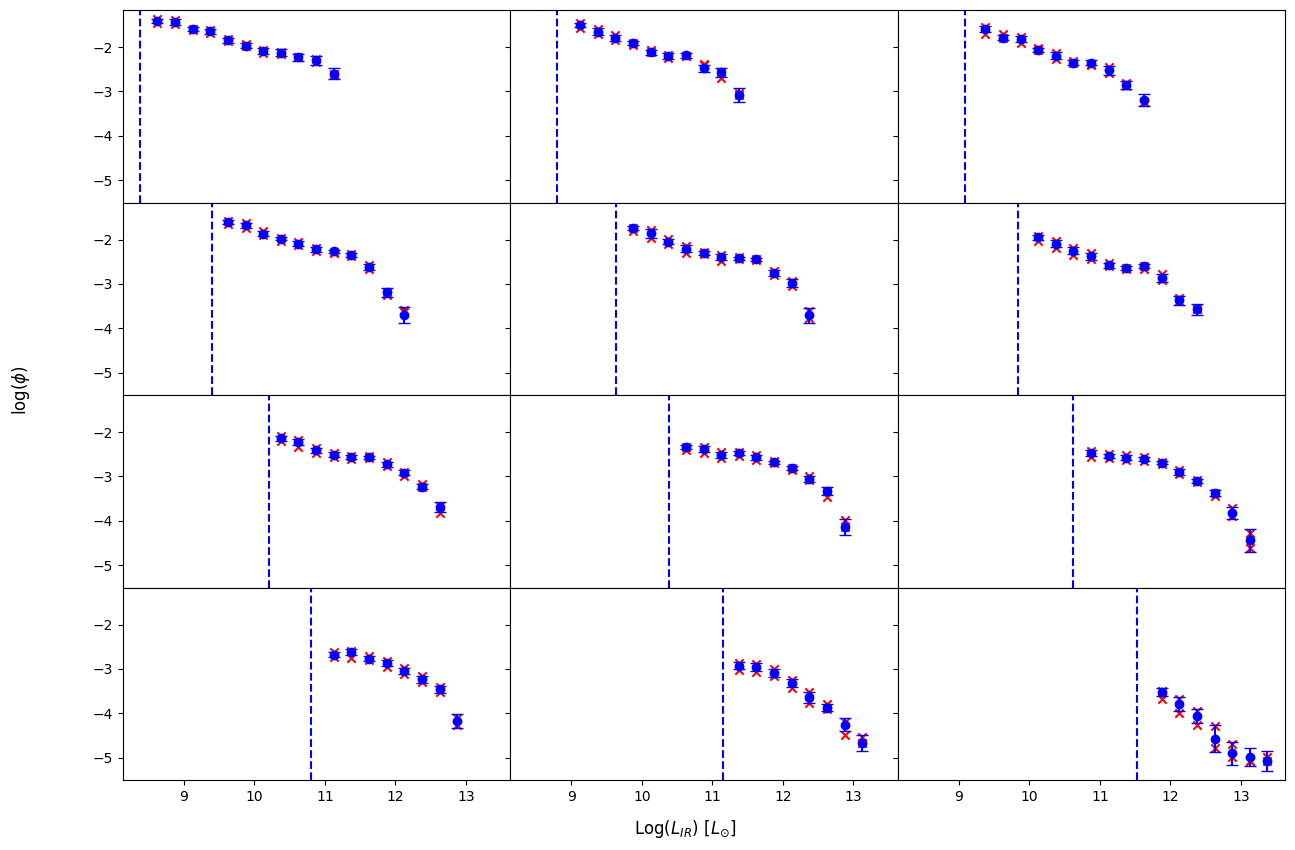

In [43]:
phi_err_total = []

for p_e, p_up, p_dn in zip(phi_e, phi_up, phi_dn):
    
    # Compute luminosity error contribution
    phi_err_lum = np.abs(p_up - p_dn) / 2

    # Total error
    phi_err_bin = np.sqrt(p_e**2 + phi_err_lum**2)
    phi_err_total.append(phi_err_bin)

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
plot_luminosity_function(axes, lum_centers, phi, phi_err_total, redshift_bins, L_lims, 'blue')
for ax, cen_up, cen_down, pu, pd in zip(axes.flatten(), centers_up, centers_dn, phi_up, phi_dn):
    ax.scatter(cen_up, np.log10(pu), color='red', label='Up Error', marker='x')
    ax.scatter(cen_down, np.log10(pd), color='red', label='Down Error', marker='x')
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()   

C:\Users\n10480129\AppData\Local\Temp\ipykernel_17924\1998526709.py:36: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_17924\1998526709.py:39: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *(params+perr))),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_17924\1998526709.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))), color='red', alpha=0.2)


0.0 <= z < 0.3 Function fit:
Lstar:    10.183 +- 0.144
phi_star: -1.726 +- 0.129

0.3 <= z < 0.45 Function fit:
Lstar:    10.283 +- 0.149
phi_star: -1.762 +- 0.164

0.45 <= z < 0.6 Function fit:
Lstar:    10.487 +- 0.139
phi_star: -1.843 +- 0.156

0.6 <= z < 0.8 Function fit:
Lstar:    11.059 +- 0.171
phi_star: -1.929 +- 0.132

0.8 <= z < 1.0 Function fit:
Lstar:    11.122 +- 0.211
phi_star: -2.029 +- 0.16

1.0 <= z < 1.2 Function fit:
Lstar:    11.283 +- 0.185
phi_star: -2.211 +- 0.152

1.2 <= z < 1.7 Function fit:
Lstar:    12.086 +- 0.068
phi_star: -2.541 +- 0.101

1.7 <= z < 2.0 Function fit:
Lstar:    12.492 +- 0.028
phi_star: -2.708 +- 0.066

2.0 <= z < 2.5 Function fit:
Lstar:    12.534 +- 0.04
phi_star: -2.782 +- 0.071

2.5 <= z < 3.0 Function fit:
Lstar:    12.46 +- 0.01
phi_star: -2.873 +- 0.07

3.0 <= z < 4.2 Function fit:
Lstar:    12.314 +- 0.014
phi_star: -3.041 +- 0.091

4.2 <= z < 6.0 Function fit:
Lstar:    11.769 +- 0.312
phi_star: -2.892 +- 0.053



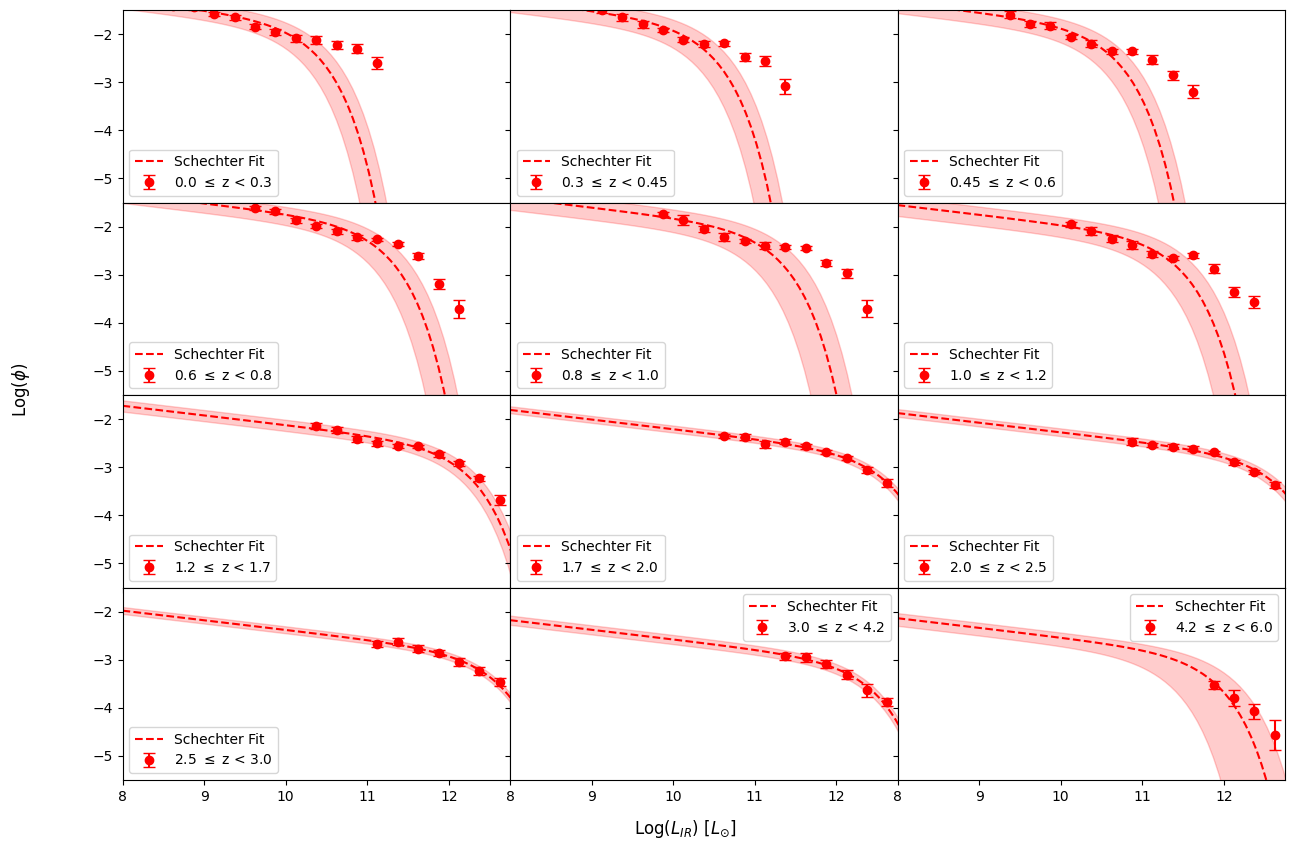

In [44]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, p_up, p_dn, e, ax in zip(redshift_bins, lum_centers, phi, phi_up, phi_dn, phi_err_total, axes.flatten()):
    
    # Attempt to fit the data
    lum = np.power(10, lum)
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Fit the data
    up_params, up_covars = curve_fit(schechter_luminosity, lum, p_up, p0=p0, bounds=bounds, maxfev=1000)
    params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
    dn_params, dn_covars = curve_fit(schechter_luminosity, lum, p_dn, p0=p0, bounds=bounds, maxfev=1000)
    
    # # Error on the parameters
    up_perr = np.sqrt(np.diag(up_covars))
    perr = np.sqrt(np.diag(covars))
    dn_perr = np.sqrt(np.diag(dn_covars))
    
    up_e = (up_params + up_perr) - params
    dn_e = params - (dn_params - dn_perr)
    sig = (up_e + dn_e) / 2
    perr = np.sqrt(perr**2 + sig**2)
    
    # Plot the data
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, fmt='o', capsize=4, color='red', label=f'{z_start} $\leq$ z < {z_end}')
    
    # Plot the Schechter function
    long_lum = np.logspace(8, 14.5, 100)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    
    ax.fill_between(np.log10(long_lum), 
        np.log10(schechter_luminosity(long_lum, *(params+perr))), 
        np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))), color='red', alpha=0.2)
    ax.set_ylim(-5.5, -1.5)
    ax.set_xlim(8, 12.75)
    ax.legend()
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Lstar:    {np.round(np.log10(params[0]),3)} +- {np.round(perr[0] / (params[0]*np.log(10)),3)}')
    print(f'phi_star: {np.round(np.log10(params[1]),3)} +- {np.round(perr[1] / (params[1]*np.log(10)),3)}')
    print()
    
    schecter_params.append(params)
    schecter_errors.append(perr)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

0.0 <= z < 0.3 Function fit:
Lstar:    9.09 +- 0.165
phi_star: -1.537 +- 0.157

0.3 <= z < 0.45 Function fit:
Lstar:    9.078 +- 0.156
phi_star: -1.494 +- 0.169

0.45 <= z < 0.6 Function fit:
Lstar:    9.445 +- 0.149
phi_star: -1.634 +- 0.166

0.6 <= z < 0.8 Function fit:
Lstar:    10.185 +- 0.179
phi_star: -1.797 +- 0.14

0.8 <= z < 1.0 Function fit:
Lstar:    10.4 +- 0.246
phi_star: -1.938 +- 0.181

1.0 <= z < 1.2 Function fit:
Lstar:    10.506 +- 0.211
phi_star: -2.094 +- 0.152

1.2 <= z < 1.7 Function fit:
Lstar:    11.458 +- 0.088
phi_star: -2.507 +- 0.103

1.7 <= z < 2.0 Function fit:
Lstar:    11.875 +- 0.036
phi_star: -2.689 +- 0.076

2.0 <= z < 2.5 Function fit:
Lstar:    11.877 +- 0.043
phi_star: -2.739 +- 0.082

2.5 <= z < 3.0 Function fit:
Lstar:    11.749 +- 0.013
phi_star: -2.795 +- 0.073

3.0 <= z < 4.2 Function fit:
Lstar:    11.547 +- 0.017
phi_star: -2.925 +- 0.093

4.2 <= z < 6.0 Function fit:
Lstar:    11.69 +- 0.027
phi_star: -3.434 +- 0.127



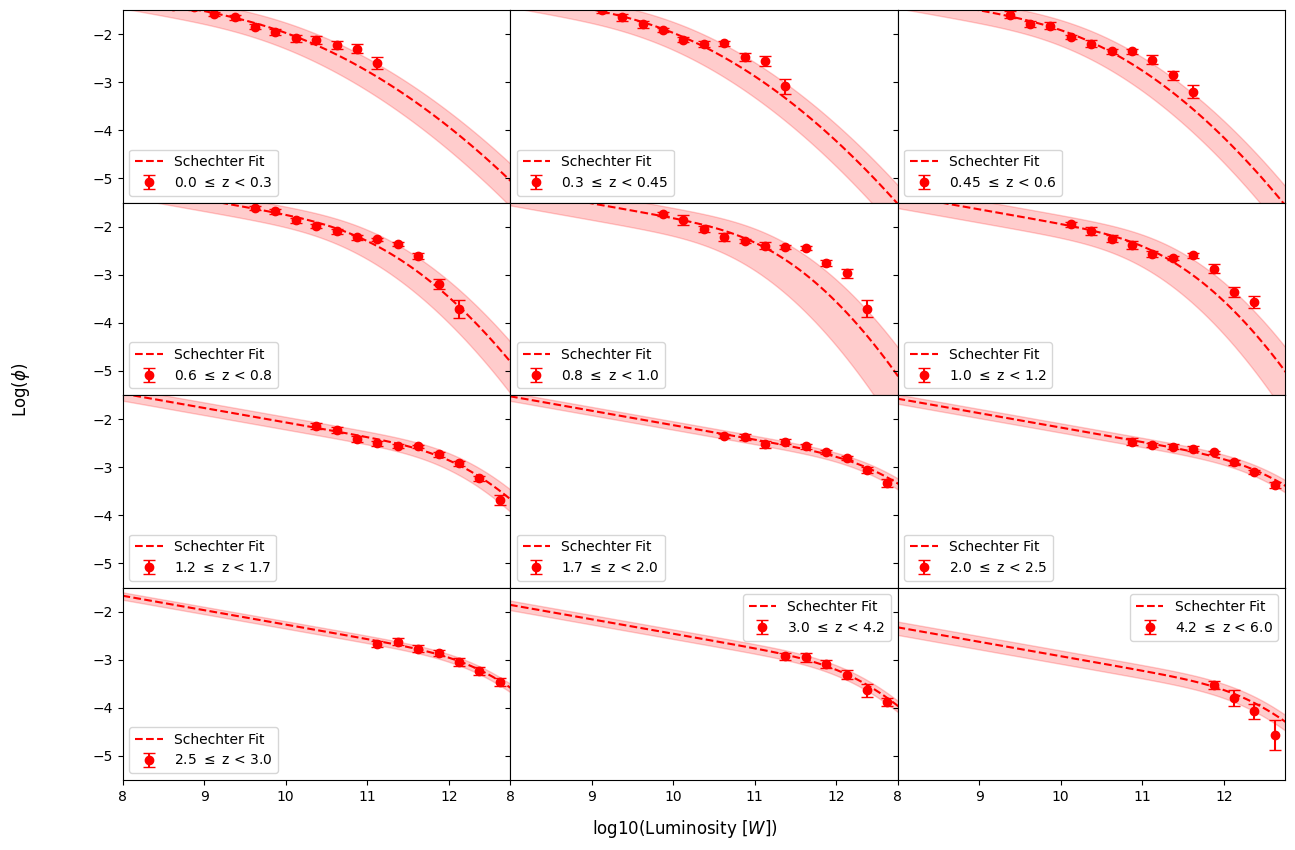

In [45]:
def saunders_luminosity(L, L_star, phi_star, sigma):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
sigmas = [1.1, 1.0, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
# sigmas = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, p_up, p_dn, e, ax, sigma in zip(redshift_bins, lum_centers, phi, phi_up, phi_dn, phi_err_total, axes.flatten(), sigmas):
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Fit the data
    up_params, up_covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p_up, p0=p0, bounds=bounds, maxfev=10000)
    params, covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p, p0=p0, bounds=bounds, maxfev=10000)
    dn_params, dn_covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p_dn, p0=p0, bounds=bounds, maxfev=10000)
    
    # Error on the parameters
    up_perr = np.sqrt(np.diag(up_covars))
    perr = np.sqrt(np.diag(covars))
    dn_perr = np.sqrt(np.diag(dn_covars))
    
    up_e = (up_params + up_perr) - params
    dn_e = params - (dn_params - dn_perr)
    sig = (up_e + dn_e) / 2
    perr = np.sqrt(perr**2 + sig**2)
    
    # Plot the data
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, fmt='o', capsize=4, color='red', label=f'{z_start} $\leq$ z < {z_end}')
    
    # Plot the Saunders function
    long_lum = np.logspace(8, 14.5, 100)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='red', label='Schechter Fit', linestyle='--')
    
    # Fill between
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *(params+perr), sigma)), 
        np.log10(saunders_luminosity(long_lum, *np.abs(params-perr), sigma)), color='red', alpha=0.2)
    ax.set_ylim(-5.5, -1.5)
    ax.set_xlim(8, 12.75)
    ax.legend()
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Lstar:    {np.round(np.log10(params[0]),3)} +- {np.round(perr[0] / (params[0]*np.log(10)),3)}')
    print(f'phi_star: {np.round(np.log10(params[1]),3)} +- {np.round(perr[1] / (params[1]*np.log(10)),3)}')
    print()
    
    saunder_params.append(params)
    saunder_error.append(perr)
    
fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

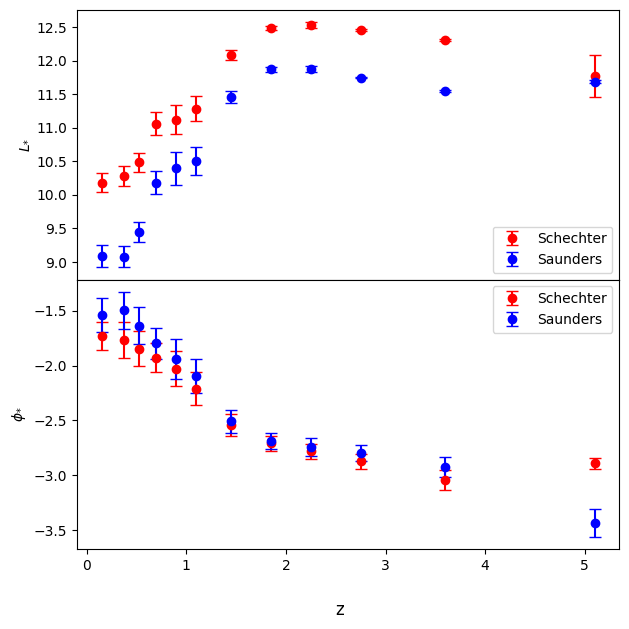

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
mean_z = np.mean(redshift_bins, axis=1)

ax[0].errorbar(mean_z, np.log10(np.array(schecter_params).T[0]), yerr=(np.array(schecter_errors).T[0] / (np.array(schecter_params).T[0] * np.log(10))), fmt='o', label='Schechter', capsize=4, color='red')
ax[0].errorbar(mean_z, np.log10(np.array(saunder_params).T[0]), yerr=(np.array(saunder_error).T[0] / (np.array(saunder_params).T[0] * np.log(10))), fmt='o', label='Saunders', capsize=4, color='blue')
ax[0].set_ylabel('$L_{*}$')
ax[0].legend(loc='lower right')

ax[1].errorbar(mean_z, np.log10(np.array(schecter_params).T[1]), yerr=(np.array(schecter_errors).T[1] / (np.array(schecter_params).T[1] * np.log(10))), fmt='o', label='Schechter', capsize=4, color='red')
ax[1].errorbar(mean_z, np.log10(np.array(saunder_params).T[1]), yerr=(np.array(saunder_error).T[1] / (np.array(saunder_params).T[1] * np.log(10))), fmt='o', label='Saunders', capsize=4, color='blue')
ax[1].set_ylabel('$\phi_{*}$')
ax[1].legend(loc='upper right')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

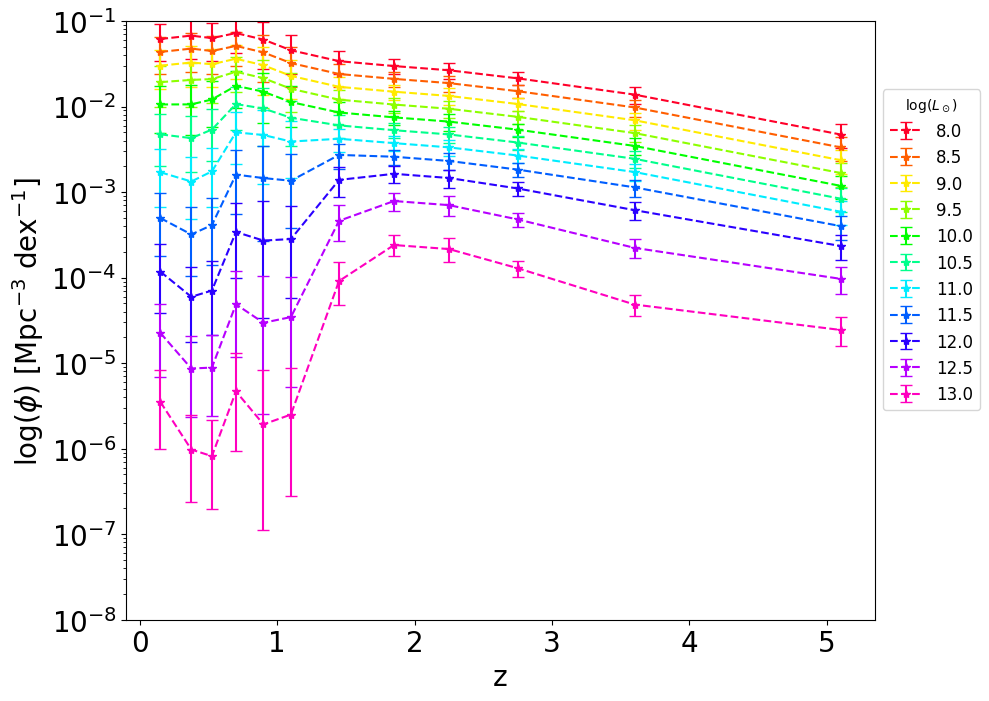

In [47]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_classes = np.arange(8, 13.5, 0.5)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_classes)))
plt.figure(figsize=(10, 7))

class_phi = []
for lum in luminosity_classes:
    lum_phi = []
    for params, perr, sigma in zip(saunder_params, saunder_error, sigmas):
    # for params, perr in zip(schecter_params, schecter_errors):
        phis = saunders_luminosity(10**lum, *params, sigma)
        phi_up = saunders_luminosity(10**lum, *(params+perr), sigma)
        phi_down = saunders_luminosity(10**lum, *np.abs(params-perr), sigma)
        # phis = schechter_luminosity(10**lum, *params)
        # phi_up = schechter_luminosity(10**lum, *(params+perr))
        # phi_down = schechter_luminosity(10**lum, *(params-perr))
        lum_phi.append([phis, phi_up-phis, np.abs(phis-phi_down)])
    class_phi.append(lum_phi)

for lum, lclass, c in zip(luminosity_classes, class_phi, colors):
    class_lum = np.array(lclass)
    phis = class_lum[:,0]
    phi_up = class_lum[:,1]
    phi_down = class_lum[:,2]
    plt.errorbar(redshift_centers, phis, yerr=[phi_down, phi_up], ls='--', capsize=4, marker='*', label=f'{lum}', color=c)

plt.legend(bbox_to_anchor=(1,0.9), title='log($L_\odot$)', fontsize=12)
plt.yscale('log')
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.xticks([0,1,2,3,4,5])
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.ylim(10**-8, 10**-1)
plt.show()

[0, 100.0, 10000.0, 1000000.0, 100000000.0, 10000000000.0, 1000000000000.0, 100000000000000.0, 1e+16, 1e+18, 1e+20, 1e+22, 1e+24, 1e+26, 1e+28, 1e+30]
[100.0, 10000.0, 1000000.0, 100000000.0, 10000000000.0, 1000000000000.0, 100000000000000.0, 1e+16, 1e+18, 1e+20, 1e+22, 1e+24, 1e+26, 1e+28, 1e+30, inf]
up_e = [0.38 0.39 0.37 0.38 0.53 0.44 0.21 0.12 0.13 0.09 0.11 0.16]
area = [8.67 8.54 8.62 9.04 8.97 8.92 9.46 9.7  9.65 9.47 9.13 8.77]
dn_e = [0.26 0.26 0.26 0.26 0.32 0.29 0.17 0.11 0.12 0.08 0.11 0.15] 

0.0 <= z < 0.3 - LD Cont - FIRGs: 48.37% - LIRGs: 32.38% - ULIRGs: 19.25% - Dominant: FIRG
0.3 <= z < 0.45 - LD Cont - FIRGs: 61.99% - LIRGs: 28.42% - ULIRGs: 9.59% - Dominant: FIRG
0.45 <= z < 0.6 - LD Cont - FIRGs: 60.82% - LIRGs: 30.84% - ULIRGs: 8.34% - Dominant: FIRG
0.6 <= z < 0.8 - LD Cont - FIRGs: 40.56% - LIRGs: 42.96% - ULIRGs: 16.48% - Dominant: LIRG
0.8 <= z < 1.0 - LD Cont - FIRGs: 42.18% - LIRGs: 45.47% - ULIRGs: 12.35% - Dominant: LIRG
1.0 <= z < 1.2 - LD Cont - FIRGs

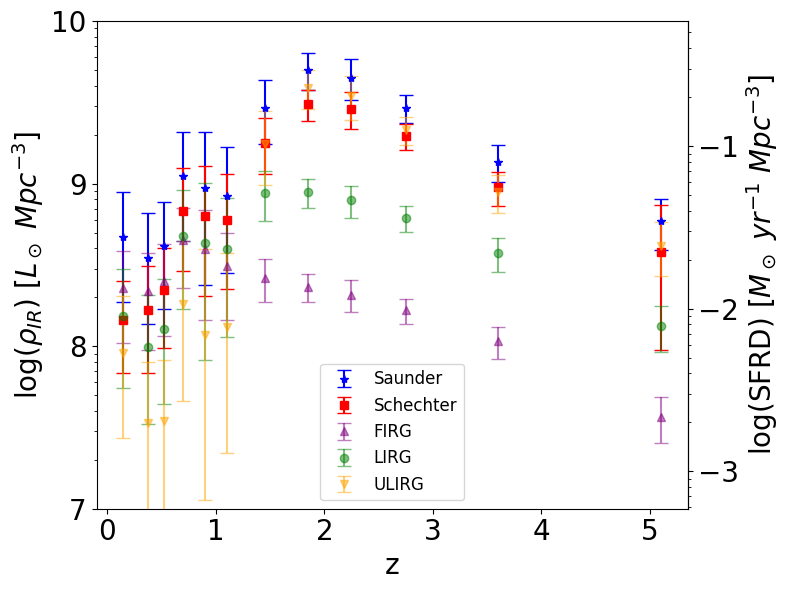

In [49]:
# lower_bound = 10**8
# upper_bound = 10**14

full_lower_bounds = np.power(10.0, np.arange(0, 32, 2)).tolist()
full_lower_bounds[0] = 0
full_upper_bounds = full_lower_bounds[1:] + [np.inf]

print(full_lower_bounds)
print(full_upper_bounds)

fig, ax = plt.subplots(figsize=(8, 6))
from scipy import integrate
from matplotlib.ticker import LogFormatterExponent

def kennicutt_sfr(rho_ir):
    return rho_ir / (1.7*10**10)

def inverse_kennicutt_sfr(sfr):
    return sfr * 1.7*10**10

def saunder_area(params, perrors, sigmas, lb, ub):
    results_area = []
    for param, perr, sigma in zip(params, perrors, sigmas):
        param = np.append(param, sigma)
        perr = np.append(perr, 0)
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

def schechter_area(params, perrors, lb, ub):
    results_area = []
    for param, perr in zip(params, perrors):
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

""" Saunder """
total_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, total_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='*', label='Saunder', color='Blue')
print(f'up_e = {np.round(area_up / (total_area* np.log(10)),2)}')
print(f'area = {np.round(np.log10(total_area),2)}')
print(f'dn_e = {np.round(area_down / (total_area* np.log(10)),2)}', '\n')
    
""" Schechter """
area, area_up, area_down = schechter_area(schecter_params, schecter_errors, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, area, yerr=[area_down, area_up], ls='none', capsize=5, marker='s', label='Schechter', color='red')

""" Saunder FIRG Contribution """
FIRG_LB = [0,      10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]
FIRG_UB = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10, 10**11]
FIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, FIRG_LB, FIRG_UB)
ax.errorbar(redshift_centers, FIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='^', label='FIRG', color='purple', alpha=0.5)

""" Saunder LIRG Contribution """
LIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, [10**11], [10**12])
ax.errorbar(redshift_centers, LIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='o', label='LIRG', color='green', alpha=0.5)

""" Saunder ULIRG Contribution """
ULIRG_LB = [10**12, 10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28]
ULIRG_UB = [10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28, np.inf]
ULIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, ULIRG_LB, ULIRG_UB)
ax.errorbar(redshift_centers, ULIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='v', label='ULIRG', color='orange', alpha=0.5)

# Relative Contributions
total_area = np.array(total_area)
FIRG_area = np.round((np.array(FIRG_area) / total_area)*100, 2)
LIRG_area = np.round((np.array(LIRG_area) / total_area)*100, 2)
ULIRG_area = np.round((np.array(ULIRG_area) / total_area)*100, 2)
for FD, LD, UD, (z_start, z_end) in zip(FIRG_area, LIRG_area, ULIRG_area, redshift_bins):
    if FD > LD and FD > UD:
        field = 'FIRG'
    elif LD > FD and LD > UD:
        field = 'LIRG'
    else:
        field = 'ULIRG'
    print(f'{z_start} <= z < {z_end} - LD Cont - FIRGs: {FD}% - LIRGs: {LD}% - ULIRGs: {UD}% - Dominant: {field}')

# Luminosity Density
ax.set_ylabel(r'log($\rho_{IR}$) [$L_\odot$ $Mpc^{-3}$]', fontsize=20)
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel('z', fontsize=20)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(10**7, 10**10)
# ax.set_ylim(10**6, 10**9.5)
ax.tick_params(axis='both', labelsize=20)
ax.yaxis.set_major_formatter(LogFormatterExponent(base=10))

# SFRD Secondary Axis
secax = ax.secondary_yaxis('right', functions=(kennicutt_sfr, inverse_kennicutt_sfr))
secax.set_ylabel('log(SFRD) [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]', fontsize=20)
secax.yaxis.set_major_formatter(LogFormatterExponent(base=10))
secax.tick_params(labelsize=20)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
file_name = 'fits/CIGALE_SF_UPDATE'
np.savez(file_name,
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object),
    e=np.array(phi_err_total, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(L_lims, dtype=object),
    s=np.array(sigmas, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object))